![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 27 - Back-propagation</center>
### <center> Forward and Backward</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/27_Backpropagation/MainBackpropagation.ipynb)

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})
np.random.seed(4)

### Get MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml

mX, vY = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
vY     = vY.astype(int)

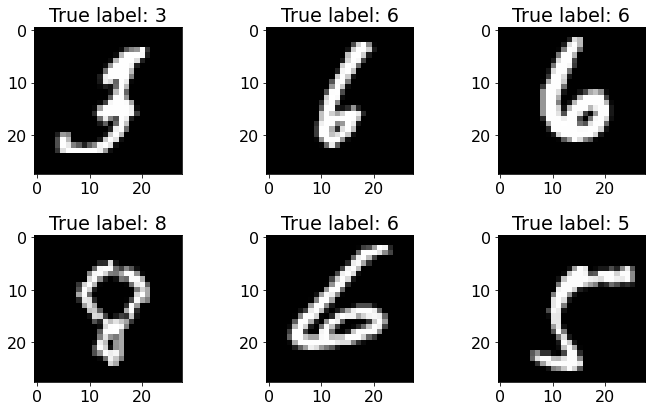

((70000, 784), (70000,))

In [3]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(10, 6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow   (np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title(f'True label: {vY[idx]}')
    
plt.tight_layout()
plt.show        ()

mX.shape, vY.shape

###  Constructing the different layers:
![a](https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/02_Backpropagation/Backpropagation.png?raw=True)
Each layer should have a `Forward` method and a `Backward` method

#### Affine (linear) layer
Forward:
$$\boldsymbol{z}=\boldsymbol{W}\boldsymbol{x}+\boldsymbol{b}$$

Gradients:
$$\boxed{\nabla_{\boldsymbol{b}}L=\nabla_{\boldsymbol{z}}L}$$
  

$$\boxed{\nabla_{\boldsymbol{x}}L=\boldsymbol{W}^{T}\nabla_{\boldsymbol{z}}L}$$

$$\boxed{\nabla_{\boldsymbol{W}}L=\nabla_{\boldsymbol{z}}L\boldsymbol{x}^{T}}$$

In [4]:
class LinearLayer:
    def __init__(self, dIn, dOut):
        mW = np.random.randn(dOut, dIn) / dIn
        vB = np.zeros(dOut)
        
        self.dParams = {'mW' : mW,   'vB' : vB}
        self.dGrads  = {'mW' : None, 'vB' : None}
        
    def Forward(self, mX):
        mW      = self.dParams['mW']
        vB      = self.dParams['vB']
        self.mX = mX                   #-- store for Backward
        mZ      = mW @ mX + vB[:,None]
        
        return mZ
    
    def Backward(self, mDz):
        mW  = self.dParams['mW']
        mX  = self.mX
        
        vDb = mDz.sum(1)
        mDw = mDz  @ mX.T
        mDx = mW.T @ mDz
        
        self.dGrads['vB'] = vDb
        self.dGrads['mW'] = mDw
                
        return mDx

#### ReLU Layer
Forward:
$$\boldsymbol{z}=\text{ReLU}\left(\boldsymbol{x}\right)=\max\left\{ \boldsymbol{x},0\right\} $$

Gradient:
$$\boxed{\nabla_{\boldsymbol{x}}L=\text{diag}\left(\mathbb{I}_{\boldsymbol{x}>0}\right)\nabla_{\boldsymbol{z}}L}$$

In [5]:
class ReLULayer:
    def __init__(self):
        self.dGrads = {}
    
    def Forward(self, mX):
        self.mX = mX                 #-- store for Backward
        mZ      = np.maximum(mX, 0)
        
        return mZ
    
    def Backward(self, mDz):
        mX    = self.mX
        mMask = (mX > 0).astype(np.float32)
        mDx   = mDz * mMask
                
        return mDx

#### It is efficient to combine the Softmax layer with the cross entropy loss

###  Loss function (Cross entropy + Softmax)
$$\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\boldsymbol{y}_{i}^{T}\log\left(\hat{\boldsymbol{y}}_{i}\right)$$
where
$$\hat{\boldsymbol{y}}=\text{softmax}\left(\boldsymbol{z}\right)=\frac{\exp\left(\boldsymbol{z}\right)}{\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)}$$

Gradient:  
$$\boxed{\nabla_{\boldsymbol{z}}\ell=\hat{\boldsymbol{y}}_{i}-\boldsymbol{y}_{i}}$$

#### Overall loss:
$$L=\frac{1}{N}\sum_{i=1}^{N}\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)$$

In [6]:
def CrossEntropyLoss(vY, mZ):
    '''
    Returns both the loss and the gradient w.r.t the input (mZ)
    '''
    N      = len(vY)
    mHatY  = np.exp(mZ)
    mHatY /= np.sum(mHatY, axis=0)
    loss   = -np.log(mHatY[vY,range(N)]).mean()
    
    mDz               = mHatY
    mDz[vY,range(N)] -= 1
    mDz              /= N
    
    return loss, mDz

### Generic model:
The model is simply a list of layers

In [7]:
class Model:
    def __init__(self, lLayers):
        self.lLayers = lLayers
        
    def Forward(self, mX):
        for oLayer in self.lLayers:
            mX = oLayer.Forward(mX)
        return mX
    
    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)
            

#-- Example:
oModel = Model([
    LinearLayer(784, 200),
    ReLULayer(),
    LinearLayer(200, 10),
])
oModel.lLayers

### Train the model:

In [8]:
def TrainModel(oModel, mX, vY, numIter, learningRate):
    
    vLoss = np.full(numIter, np.nan)
    fig   = plt.figure(figsize=(8, 4))
    for ii in range(numIter):
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)
        vLoss[ii] = loss

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (vanilla gradient descnet)
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]

        #-- Display:
        print('\rIteration: ', ii, '. loss = ', loss, end='')
        plt.cla   ()
        plt.plot  (vLoss)
        plt.xlabel('Iterations')
        plt.ylabel('Training loss')

        fig.canvas.draw()
        plt.pause(1e-10)

###  Split to train and test:

In [9]:
from sklearn.model_selection import train_test_split

Ntrain  = 60000
Ntest   = 10000
vIdx    = np.random.choice(Ntrain + Ntest, Ntrain + Ntest)
mX      = mX[vIdx,:]
vY      = vY[vIdx]

mTrainX, mTestX, vTrainY, vTestY = train_test_split(mX, vY, train_size=Ntrain, test_size=Ntest)

(mTrainX.shape, 
vTrainY.shape, 
mTestX.shape,  
vTestY.shape)

((60000, 784), (60000,), (10000, 784), (10000,))

### Train a shallow model:

<IPython.core.display.Javascript object>


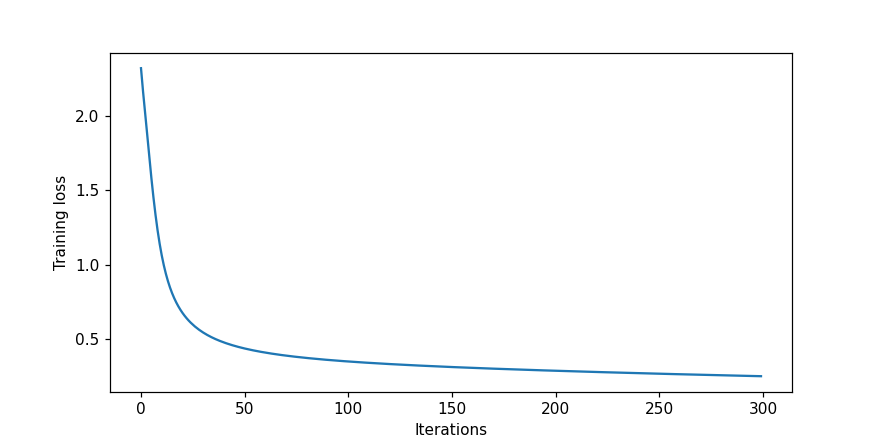

Iteration:  299 . loss =  0.24766170188424256

In [10]:
%matplotlib notebook

oModel = Model([
    LinearLayer(784, 200),
    ReLULayer(),
    LinearLayer(200, 10),
])

TrainModel(oModel, mTrainX.T, vTrainY, 300, 1e-3)

###  Check model performance:

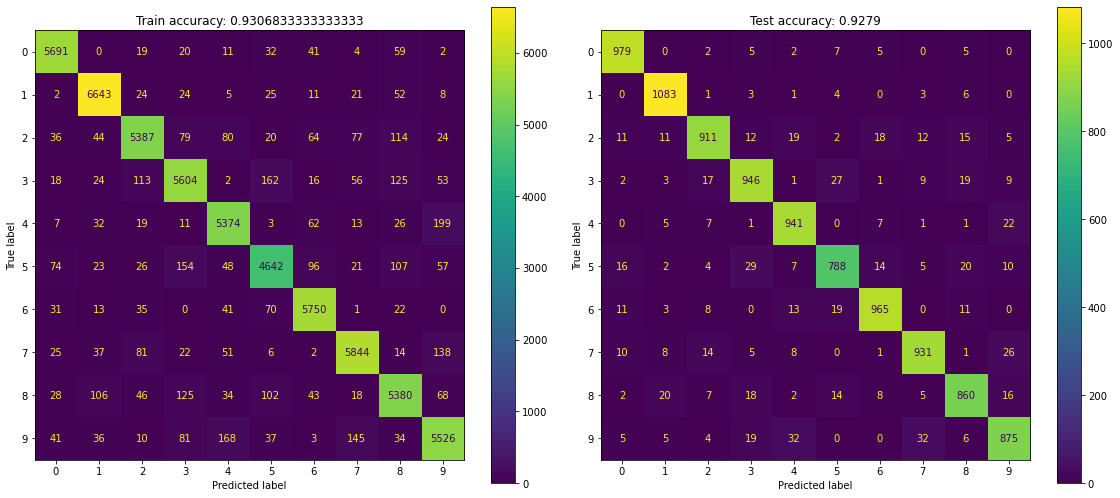

In [11]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#-- Apply model to data:
mHatTrainY = oModel.Forward(mTrainX.T)
mHatTestY  = oModel.Forward(mTestX.T )
vHatTrainY = np.argmax(mHatTrainY, axis=0)
vHatTestY  = np.argmax(mHatTestY,  axis=0)

#-- Plot condusion matrices:
mTrainConfusion = confusion_matrix(vTrainY, vHatTrainY)
mTestConfusion  = confusion_matrix(vTestY,  vHatTestY )

_, ax = plt.subplots(1, 2, figsize=(16, 7))
ConfusionMatrixDisplay(mTrainConfusion, display_labels=range(10)).plot(values_format='g', ax=ax[0])
ConfusionMatrixDisplay(mTestConfusion,  display_labels=range(10)).plot(values_format='g', ax=ax[1])
ax[0].set_title('Train accuracy: ' f'{np.mean(vTrainY == vHatTrainY)}')
ax[1].set_title('Test accuracy: '  f'{np.mean(vTestY  == vHatTestY) }')

plt.tight_layout()
plt.show()

### Train a deeper model:

<IPython.core.display.Javascript object>


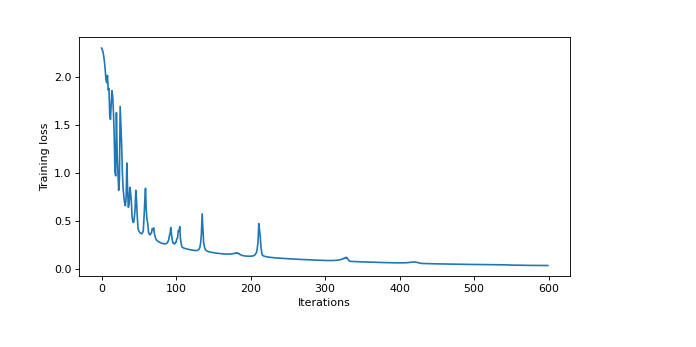

Iteration:  599 . loss =  0.036286066290968706

In [12]:
%matplotlib notebook

oModel = Model([
        LinearLayer(784, 200),
        ReLULayer(),
        LinearLayer(200, 50),
        ReLULayer(),
        LinearLayer(50, 10),
])

TrainModel(oModel, mTrainX.T, vTrainY, 600, 2e-2)

###  Check model performance:

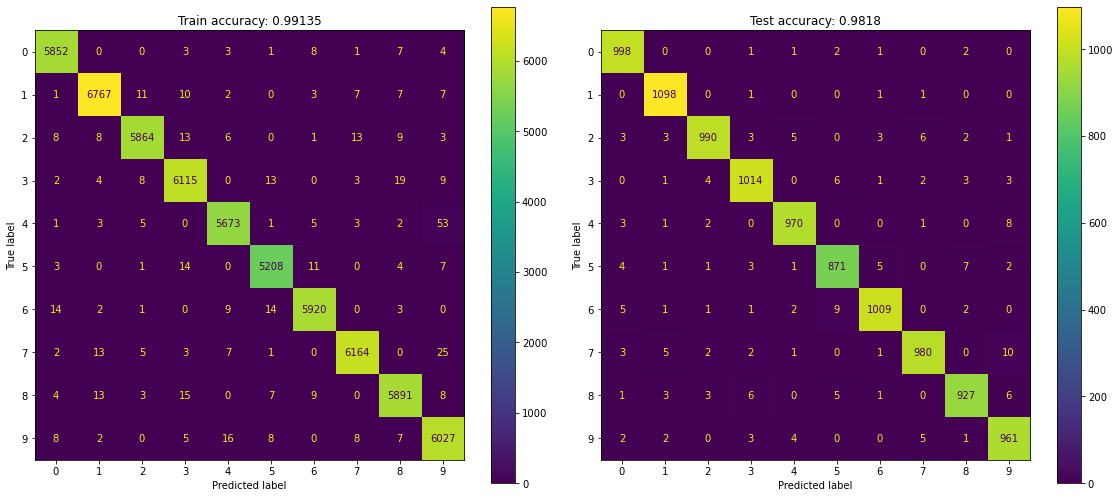

In [14]:
%matplotlib inline

#-- Apply model to data:
mHatTrainY = oModel.Forward(mTrainX.T)
mHatTestY  = oModel.Forward(mTestX.T )
vHatTrainY = np.argmax(mHatTrainY, axis=0)
vHatTestY  = np.argmax(mHatTestY,  axis=0)

#-- Plot condusion matrices:
mTrainConfusion = confusion_matrix(vTrainY, vHatTrainY)
mTestConfusion  = confusion_matrix(vTestY,  vHatTestY )

_, ax = plt.subplots(1, 2, figsize=(16, 7))
ConfusionMatrixDisplay(mTrainConfusion, display_labels=range(10)).plot(values_format='g', ax=ax[0])
ConfusionMatrixDisplay(mTestConfusion,  display_labels=range(10)).plot(values_format='g', ax=ax[1])
ax[0].set_title('Train accuracy: ' f'{np.mean(vTrainY == vHatTrainY)}')
ax[1].set_title('Test accuracy: '  f'{np.mean(vTestY  == vHatTestY) }')

plt.tight_layout()
plt.show()

### Plot wrong predictions:

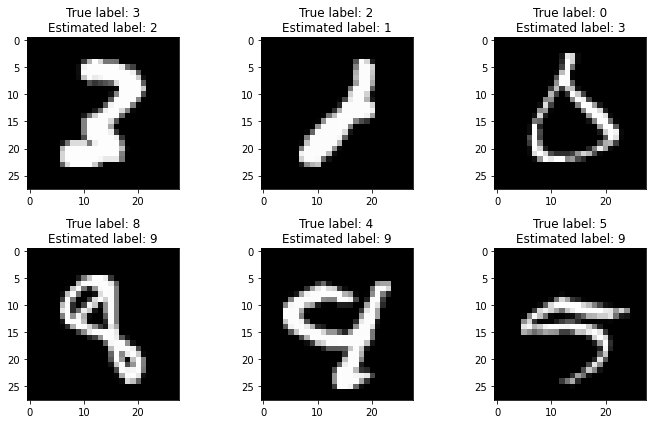

In [17]:
%matplotlib inline

#-- Apply model to data:
mHatTestY = oModel.Forward(mTestX.T)
vHatTestY = np.argmax(mHatTestY, axis=0)
vWrongIdx = np.nonzero(vTestY != vHatTestY)[0]

#-- Plot a few mistakes:
fig, _ = plt.subplots(2, 3, figsize=(10, 6))
for ax in fig.axes:
    idx = vWrongIdx[np.random.randint(len(vWrongIdx))]
    ax.imshow   (np.reshape(mTestX[idx,:], (28, 28)), cmap='gray')
    ax.set_title(f'True label: {vTestY[idx]}\nEstimated label: {vHatTestY[idx]}')
    
plt.tight_layout()
plt.show()

### Exercise
* Use the California housing dataset `fetch_california_housing`.
* Replace the cross-entropy loss with the MSE loss, that is:
$$\ell_{i}=\left(\hat{y}_{i}-y_{i}\right)^{2}$$
where $y_{i}\in\mathbb{R}$ is the true value and $\hat{y}_{i}\in\mathbb{R}$
is the model output.
* Try to get the best MSE\R2 score you can ($R^2$ above 0.7 is OK).  


**Tips:**
* You should test different models (layers\activations) and hyper-parameters.
* Make sure your results are better than linear regression.


**Optional:**
* implement the Leaky-ReLU layer:
$$\text{Leaky_ReLU}\left(x\right)=\begin{cases}
x & x\geq0\\
0.01x & x<0
\end{cases}$$

In [51]:
from sklearn.datasets import fetch_california_housing

mX, vY  = fetch_california_housing(return_X_y=True)
mX     -= np.mean(mX, axis=0)
mX     /= np.std (mX, axis=0)

mX.shape, vY.shape

((20640, 8), (20640,))

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics      import r2_score

oReg  = LinearRegression().fit(mX, vY)
vHatY = oReg.predict(mX)
print(f'MSE = {np.linalg.norm(vHatY - vY)**2 / len(vY)}')
print(f'R²  = {r2_score(vY, vHatY)}')

MSE = 0.5243209861846072
R²  = 0.606232685199805


In [53]:
np.std(vY)

1.1539282040412253

In [24]:
Ntrain  = 15000
Ntest   = 5640
vIdx    = np.random.choice(Ntrain + Ntest, Ntrain + Ntest)
mX      = mX[vIdx,:]
vY      = vY[vIdx]

mTrainX, mTestX, vTrainY, vTestY = train_test_split(mX, vY, train_size=Ntrain, test_size=Ntest)

(mTrainX.shape, 
vTrainY.shape, 
mTestX.shape,  
vTestY.shape)

((15000, 8), (15000,), (5640, 8), (5640,))

$$L=\mathrm{MSE}=\frac{1}{N}\sum_{i=1}^{N}\left(\hat{y}_{i}-y_{i}\right)^{2}$$
* Compute the loss $L$ (`loss`) and the gradient $\nabla_{\hat{\boldsymbol{y}}}L$ (`vDy`).  
* Do not use loops.

In [ ]:
def MSE(vY, vHatY):
    
    ???
    
    return loss, vDy

In [27]:
def TrainModel(oModel, mX, vY, numIter, learningRate):
    fig   = plt.figure(figsize=(8, 4))
    vLoss = np.full(numIter, np.nan)

    for ii in range(numIter):

        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = ???
        vLoss[ii] = loss

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (vanilla gradient descnet)
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]

        #-- Display:
        print('Iteration: ', ii, '. loss = ', loss, '\r', end='')
        plt.cla   ()
        plt.plot  (vLoss)
        plt.xlabel('Iterations')
        plt.ylabel('Training loss')
        
        fig.canvas.draw()
        plt.pause(1e-20)

SyntaxError: invalid syntax (<ipython-input-27-ebac40273227>, line 9)

In [32]:
%matplotlib notebook

oModel = Model([
    ???
])

TrainModel(oModel, mTrainX.T, vTrainY, ???, ???)

SyntaxError: invalid syntax (<ipython-input-32-0dc57b76139a>, line 4)

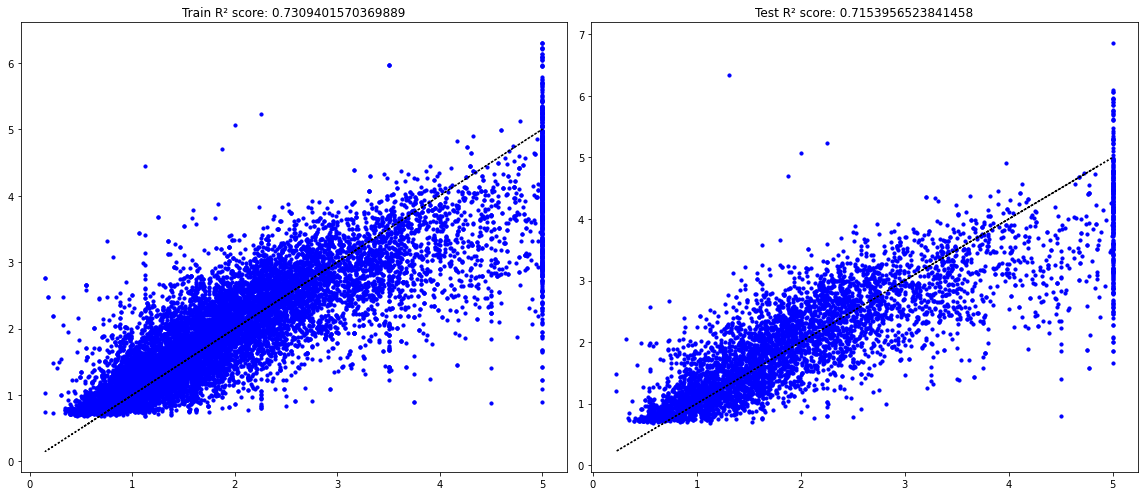

In [15]:
%matplotlib inline

from sklearn.metrics import r2_score

#-- Apply model to data:
vHatTrainY = oModel.Forward(mTrainX.T).squeeze()
vHatTestY  = oModel.Forward(mTestX.T ).squeeze()

_, ax = plt.subplots(1, 2, figsize=(16,7))

ax[0].scatter   (vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter   (vTestY,  vHatTestY,  s=10, c='b', edgecolor=None)
ax[0].plot      (vTrainY, vTrainY, ':k')
ax[1].plot      (vTestY,  vTestY,  ':k')
ax[0].set_title ('Train $R^2$ score:' f'{r2_score(vTrainY, vHatTrainY)}')
ax[1].set_title ('Test $R^2$ score:'  f'{r2_score(vTestY,  vHatTestY) }')
ax[0].set_xlabel('$y_i$')
ax[1].set_xlabel('$y_i$')
ax[0].set_ylabel('$\hat{y}_i$')
ax[1].set_ylabel('$\hat{y}_i$')
plt.tight_layout()
plt.show()

In [28]:
class LeakyReLULayer:
    def __init__(self, slope=0.01):
        self.dGrads = {}
        self.slope  = slope
    
    def Forward(self, mX):
        self.mX = mX #-- store for Backward
        mZ      = ???
        
        return mZ
    
    def Backward(self, mDz):
        mX    = self.mX
        mMask = ???
        
        mDx   = mDz * mMask
                
        return mDx

SyntaxError: invalid syntax (<ipython-input-28-4dc97bad36f7>, line 8)